### Import libraries

In [1]:
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

### Visualizing one file

In [2]:
example = loadmat('ictal/patient_1_1.mat')

In [8]:
print (example['data'])

[[  5562 -20218   5929 ...  11626  13689  10458]
 [  5575 -20220   5940 ...  11625  13689  10457]
 [  5595 -20221   5959 ...  11624  13688  10456]
 ...
 [  5552 -20251   5921 ...  11567  13656  10436]
 [  5562 -20253   5930 ...  11566  13655  10435]
 [  5559 -20253   5927 ...  11567  13656  10437]]


In [10]:
samples, channels = ((example['data']).shape)

In [11]:
print (samples)
print (channels)

5000
96


In [12]:
time = np.arange(samples)

In [14]:
channel1 = example['data'][:,0]

In [ ]:
def convert_file_to_sample(filename):
    data = loadmat(filename)
    samples, channels = (data['data'].shape)
    

In [15]:
plt.plot(time, channel1)

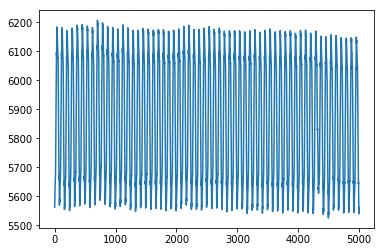

In [16]:
plt.show()

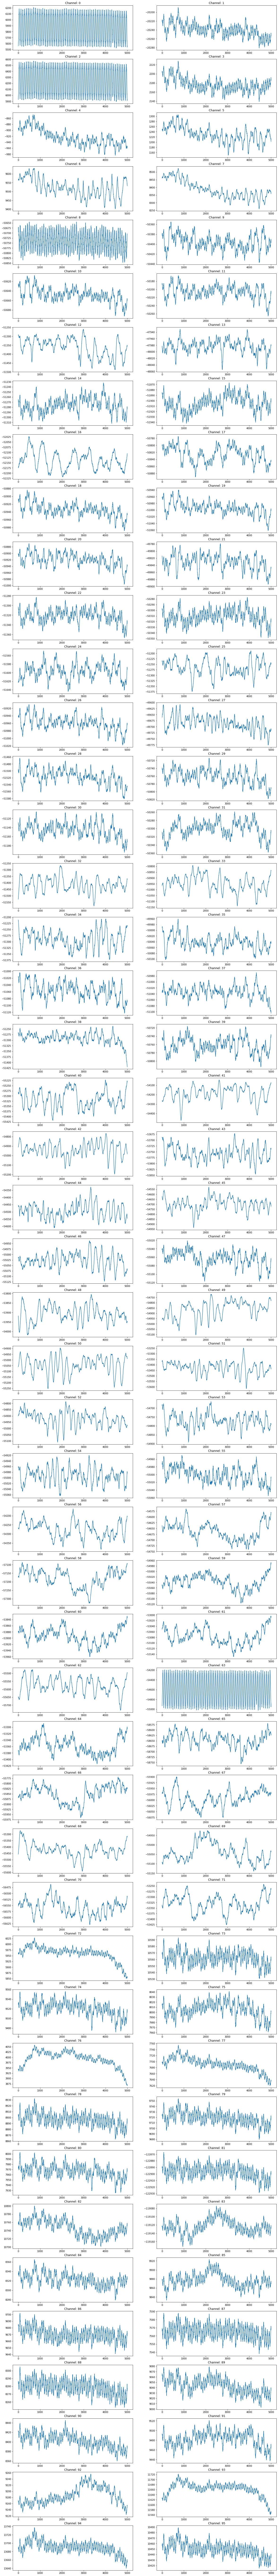

In [21]:
fig = plt.figure(figsize=(20,200))
for c in range(channels):
    channel = example['data'][:,c]
    plt.subplot(48,2,c+1)
    plt.plot(time, channel)
    plt.title("Channel: " + str(c))

plt.show()